In [1]:
require 'torch'

os.execute('wget -c http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz')
os.execute('tar -xvf cifar-10-binary.tar.gz')
local function convertCifar10BinToTorchTensor(inputFnames, outputFname)
   local nSamples = 0
   for i=1,#inputFnames do
      local inputFname = inputFnames[i]
      local m=torch.DiskFile(inputFname, 'r'):binary()
      m:seekEnd()
      local length = m:position() - 1
      local nSamplesF = length / 3073 -- 1 label byte, 3072 pixel bytes
      assert(nSamplesF == math.floor(nSamplesF), 'expecting numSamples to be an exact integer')
      nSamples = nSamples + nSamplesF
      m:close()
   end

   local label = torch.ByteTensor(nSamples)
   local data = torch.ByteTensor(nSamples, 3, 32, 32)

   local index = 1
   for i=1,#inputFnames do
      local inputFname = inputFnames[i]
      local m=torch.DiskFile(inputFname, 'r'):binary()
      m:seekEnd()
      local length = m:position() - 1
      local nSamplesF = length / 3073 -- 1 label byte, 3072 pixel bytes
      m:seek(1)
      for j=1,nSamplesF do
         label[index] = m:readByte()
         local store = m:readByte(3072)
         data[index]:copy(torch.ByteTensor(store))
         index = index + 1
      end
      m:close()
   end

   local out = {}
   out.data = data
   out.label = label
   print(out)
   torch.save(outputFname, out)
end

convertCifar10BinToTorchTensor({'cifar-10-batches-bin/data_batch_1.bin',
                                'cifar-10-batches-bin/data_batch_2.bin',
                                'cifar-10-batches-bin/data_batch_3.bin',
                                'cifar-10-batches-bin/data_batch_4.bin',
                                'cifar-10-batches-bin/data_batch_5.bin'},
   'cifar10-train.t7')

convertCifar10BinToTorchTensor({'cifar-10-batches-bin/test_batch.bin'},
   'cifar10-test.t7')

cifar-10-batches-bin/
cifar-10-batches-bin/data_batch_1.bin


cifar-10-batches-bin/batches.meta.txt
cifar-10-batches-bin/data_batch_3.bin


cifar-10-batches-bin/data_batch_4.bin


cifar-10-batches-bin/test_batch.bin


cifar-10-batches-bin/readme.html


cifar-10-batches-bin/data_batch_5.bin


cifar-10-batches-bin/data_batch_2.bin


{
  data : ByteTensor - size: 50000x3x32x32
  label : ByteTensor - size: 50000
}


{


  data : ByteTensor - size: 10000x3x32x32
  label : ByteTensor - size: 10000
}


In [2]:
require 'nn';
require 'paths'
trainset = torch.load('cifar10-train.t7')
testset = torch.load('cifar10-test.t7')
classes = {'airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [3]:
trainset.label = trainset.label+1
testset.label = testset.label+1

In [4]:
-- ignore setmetatable for now, it is a feature beyond the scope of this tutorial. It sets the index operator.
setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
trainset.data = trainset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function trainset:size() 
    return self.data:size(1) 
end

-- ignore setmetatable for now, it is a feature beyond the scope of this tutorial. It sets the index operator.
setmetatable(testset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
testset.data = testset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function testset:size() 
    return self.data:size(1) 
end

In [5]:
r = trainset.data[{ {}, {1}, {}, {}  }]*0.21
g = trainset.data[{ {}, {2}, {}, {}  }]*0.72
b = trainset.data[{ {}, {3}, {}, {}  }]*0.07
trainset.data = r+g+b
r = testset.data[{ {}, {1}, {}, {}  }]*0.21
g = testset.data[{ {}, {2}, {}, {}  }]*0.72
b = testset.data[{ {}, {3}, {}, {}  }]*0.07
testset.data = r+g+b

automobile	
2	


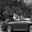

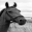

horse	
8	


In [6]:
itorch.image(trainset.data[100]) -- display the 100-th image in dataset
print(classes[trainset.label[100]])
print(trainset.label[100])
itorch.image(testset.data[100]) -- display the 100-th image in dataset
print(classes[testset.label[100]])
print(testset.label[100])

In [7]:
mean = {} -- store the mean, to normalize the test set in the future
stdv  = {} -- store the standard-deviation for the future
for i=1,1 do -- over each image channel
    mean[i] = trainset.data[{ {}, {i}, {}, {}  }]:mean() -- mean estimation
    print('Channel ' .. i .. ', Mean: ' .. mean[i])
    trainset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction
    
    stdv[i] = trainset.data[{ {}, {i}, {}, {}  }]:std() -- std estimation
    print('Channel ' .. i .. ', Standard Deviation: ' .. stdv[i])
    trainset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end
mean = {} -- store the mean, to normalize the test set in the future
stdv  = {} -- store the standard-deviation for the future

Channel 1, Mean: 122.80931339391	


Channel 1, Standard Deviation: 61.229392750446	


In [8]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(1, 6, 5, 5)) -- 3 input image channels, 6 output channels, 5x5 convolution kernel
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(120, 84))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax(1)) 

In [15]:
criterion = nn.ClassNLLCriterion()

In [10]:
require 'cunn';

In [16]:
net = net:cuda()

In [17]:
criterion = criterion:cuda()

In [18]:
trainset.data = trainset.data:cuda()
trainset.label = trainset.label:cuda()
testset.data = testset.data:cuda()
testset.label = testset.label:cuda()

In [19]:
trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.001
trainer.maxIteration = 10 -- just do 5 epochs of training.

In [20]:
tstart=os.time()
trainer:train(trainset)
tend=os.time()
print(os.difftime (tend , tstart))

# StochasticGradient: training	


# current error = 1.9166581060696	


# current error = 1.5316637751555	


# current error = 1.3497945787978	


# current error = 1.2188308301401	


# current error = 1.1261821846294	


# current error = 1.0545580923319	


# current error = 0.99495678667545	


# current error = 0.94322364642382	


# current error = 0.89797569434166	


# current error = 0.85599119363546	
# StochasticGradient: you have reached the maximum number of iterations	
# training error = 0.85599119363546	
287	


In [21]:
correct = 0
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        correct = correct + 1
    end
end
print(correct, 100*correct/10000 .. ' % ')

2820	28.2 % 	


In [22]:
class_performance = {0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        class_performance[groundtruth] = class_performance[groundtruth] + 1
    end
end
for i=1,#classes do
    print(classes[i], 100*class_performance[i]/1000 .. ' %')
end

airplane	83.1 %	
automobile	21.3 %	
bird	1.8 %	
cat	26.2 %	
deer	0 %	
dog	71.6 %	


frog	0.5 %	
horse	13.7 %	
ship	31.9 %	
truck	31.9 %	
